In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), "stack_overflow_16k")

6053888/6053168 [==============================] - 0s 0us/step


In [10]:
dataset_dir = os.path.join(os.path.dirname(dataset), "stack_overflow_16k")
dataset_dir

'.\\stack_overflow_16k'

In [11]:
os.listdir(dataset_dir)

['README.md', 'test', 'train']

In [12]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'java', 'javascript', 'python']

In [13]:
sample_file = os.path.join(train_dir, 'python/100.txt')
with open(sample_file) as f:
  print(f.read())

"blank syntax doubt hey, i have been using the pymt library and they have this convention to referring their widgets:..from pymt import *..# create a slider from 0.-1..sl = mtxyslider()..@sl.event.def on_value_change(x, y):.    print 'slider value change', x, y..runtouchapp(sl)...what's with the ""@""? what does it signify in blank?thanks."



In [14]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [15]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("Question: ", text_batch.numpy()[i])
        print("Label :", label_batch.numpy()[i])

Question:  b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default con

In [16]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [17]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [18]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stack_overflow_16k/test', 
    batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [30]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [31]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [32]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [33]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Question", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized question", vectorize_text(first_review, first_label))

Question tf.Tensor(b'"how to change data format in write function in blank? how to change the data format in f.write function? ..loaded_data = 349.00  or 3.00..i want to change data format in write function like %6f in print function. ..ex)  349.00 -> 349.000000 ,   3.00 -> 3.000000..f = open(""test.txt"", \'w\').f.write( str.(loaded_data).zfill(?) )  ...what is the code that performs above function?"\n', shape=(), dtype=string)
Label python
Vectorized question (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  24,    4,  175,   80,  290,    7,  174,   38,    7,   16,   24,
           4,  175,    2,   80,  290,    7, 7865,   38,    1,    1,   45,
           1,   46,    4,  175,   80,  290,    7,  174,   38,   48,    1,
           7,   75,   38,  507,    1,    1, 1544,    1,    1,    1,    1,
          55,    6,    2,   30,   14, 3374,  250,   38,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    

In [34]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  scissors
 313 --->  source
Vocabulary size: 10000


In [35]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [36]:
embedding_dim = 16

In [37]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(loss=losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

In [41]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
200/200 [==============================] - 6s 28ms/step - loss: 0.8244 - accuracy: 0.7712 - val_loss: 0.8164 - val_accuracy: 0.7588
Epoch 2/10
200/200 [==============================] - 6s 28ms/step - loss: 0.7841 - accuracy: 0.7858 - val_loss: 0.7827 - val_accuracy: 0.7619
Epoch 3/10
200/200 [==============================] - 6s 28ms/step - loss: 0.7443 - accuracy: 0.7899 - val_loss: 0.7533 - val_accuracy: 0.7700
Epoch 4/10
200/200 [==============================] - 6s 28ms/step - loss: 0.7106 - accuracy: 0.7982 - val_loss: 0.7255 - val_accuracy: 0.7825
Epoch 5/10
200/200 [==============================] - 6s 29ms/step - loss: 0.6818 - accuracy: 0.8064 - val_loss: 0.7012 - val_accuracy: 0.7850
Epoch 6/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6542 - accuracy: 0.8203 - val_loss: 0.6805 - val_accuracy: 0.7844
Epoch 7/10
200/200 [==============================] - 6s 28ms/step - loss: 0.6264 - accuracy: 0.8227 - val_loss: 0.6612 - val_accuracy: 0.7912

In [42]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 57s 219ms/step - loss: 0.6523 - accuracy: 0.7742
Loss:  0.6523345708847046
Accuracy:  0.7742499709129333


In [45]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

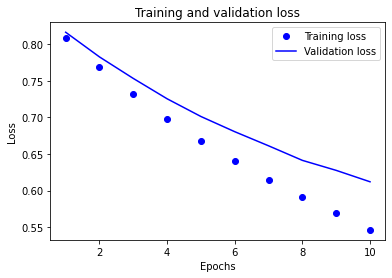

In [46]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

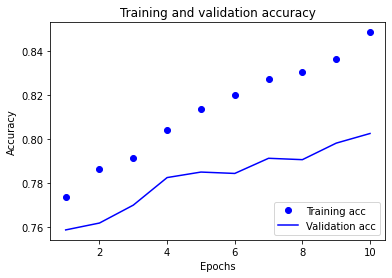

In [47]:

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [49]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 6s 21ms/step - loss: 0.6575 - accuracy: 0.7717
0.7742499709129333
